# SVC

In [1]:
%reload_ext autoreload
%autoreload 2

## Imports

In [2]:
import bz2
import os
import pickle
import sys
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy
from IPython.display import display
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

sys.path.append(os.path.abspath('../src'))
from fact_classification import *

2023-04-25 19:12:28.594408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load datafiles

In [3]:
df, df_crowdsourced, df_ground_truth = data_loading(local=True)
df['Sentiment'] = df.Sentiment.fillna(df.Sentiment[df.Verdict == -1].mean())

## Load features
Load the features matrix that we generated in the `feature_generation.ipynb` notebook. This is a large sparse matrix. We convert it to Pandas.SparseDtype to avoid running out of memory when fitting our models.

In [4]:
with bz2.open('../results/df_features.bz2') as f:
    df_features = pickle.load(f)

# Convert to compressed sparse row matrix
X = sp.sparse.csr_matrix(df_features)

## Split data and generate indexes

We split the dataset according to the instructions in the assignment, where data up until and including year 2008 will be used for training, and data after 2008 will be used for testing. Here we also generate indexes for the various feature sets.

In [5]:
df_train, df_test, idx_train = test_train_split(df)

y = df['Verdict']
y_train = df_train['Verdict']
y_test = df_test['Verdict']

X_train = X[idx_train]
X_test = X[~idx_train]

# Column index for the numeric columns Sentiment and Length
col_idx_n = (df_features.columns == 'Sentiment') | (df_features.columns == 'Length')

# Column index for TF-IDF features on the raw Text column with n-grams=1
col_idx_w1 = df_features.columns.str.startswith('W1_')

# Column index for TF-IDF features on the raw Text column with n-grams=2
col_idx_w2 = df_features.columns.str.startswith('W2_')

# Column index for TF-IDF features on the stemmed text with n-grams=1
col_idx_ws = df_features.columns.str.startswith('WS_')

# Column index for POS features
col_idx_p = df_features.columns.str.startswith('P_')

# Column index for NER labels
col_idx_e = df_features.columns.str.startswith('E_')

## Setup GridSearchCV

We use GridSearchCV from scikit-learn to get the best combination of parameters for the model. Since we have an unbalanced dataset we set `class_weight='balanced'` for the SVC. 

We use weighted f1-score for scoring the grid search, and we define a test-fold for cross validation that uses the data after 2008 as test set.

In [6]:
svc = SGDClassifier(
    class_weight='balanced',
    early_stopping=True,
    random_state=42,
)

param_grid = [
    {
        'kernel': ['rbf', 'sigmoid'],
        'gamma': [0.5, 'scale']
    },
    {
        'kernel': ['poly'],
        'degree': [2, 3],
        'gamma': [0.5, 'scale']
    }
]

clf = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=4,
    n_jobs=-1,
    return_train_score=True,
    verbose=0
)


## Define experiments

In [7]:
# Define experiments
experiments = {
    'N': col_idx_n,
    'W': col_idx_w1,
    'P': col_idx_p,
    'E': col_idx_e,
    'N_W': col_idx_n | col_idx_w1,
    'N_P': col_idx_n | col_idx_p,
    'N_E': col_idx_n | col_idx_e,
    'N_W_P': col_idx_n | col_idx_w1 | col_idx_p,
    'N_W_E': col_idx_n | col_idx_w1 | col_idx_e,
    'N_W_P_E': col_idx_n | col_idx_w1 | col_idx_p | col_idx_e
}


## Run experiments

In [8]:
df_score_train = pd.DataFrame()
df_score_test = pd.DataFrame()
models = {}

for features, index in experiments.items():
  exp_clf, exp_score_train, exp_score_test = run_experiment(
      clf=copy(clf),
      X_train=X_train[:, index],
      y_train=y_train,
      X_test=X_test[:, index],
      y_test=y_test,
      annotations={
        'algorithm': 'SVM',
        'features': features}
  )
  models[features] = exp_clf
  # Print test results
  print('Test metrics:')
  display(exp_score_test)
  # Add results to dataframe
  df_score_train = pd.concat([df_score_train, exp_score_train]).reset_index(drop=True)
  df_score_test = pd.concat([df_score_test, exp_score_test]).reset_index(drop=True)

Running experiment with algorithm "SVM" and features "N"
Best parameters found: {'gamma': 0.5, 'kernel': 'sigmoid'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,N,0.633,0.099,0.303,0.484,0.447,0.116,0.489,0.42,0.524,0.107,0.374,0.436


Running experiment with algorithm "SVM" and features "W"
Best parameters found: {'gamma': 'scale', 'kernel': 'rbf'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,W,0.798,0.424,0.634,0.711,0.858,0.371,0.558,0.722,0.827,0.396,0.594,0.715


Running experiment with algorithm "SVM" and features "P"
Best parameters found: {'gamma': 'scale', 'kernel': 'rbf'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,P,0.815,0.244,0.53,0.673,0.721,0.517,0.413,0.615,0.765,0.332,0.464,0.635


Running experiment with algorithm "SVM" and features "E"
Best parameters found: {'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,E,0.739,0.191,0.591,0.636,0.772,0.299,0.384,0.614,0.755,0.233,0.466,0.617


Running experiment with algorithm "SVM" and features "N_W"
Best parameters found: {'gamma': 0.5, 'kernel': 'rbf'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,N_W,0.809,0.351,0.633,0.709,0.822,0.457,0.525,0.701,0.816,0.397,0.574,0.703


Running experiment with algorithm "SVM" and features "N_P"
Best parameters found: {'gamma': 'scale', 'kernel': 'rbf'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,N_P,0.82,0.241,0.565,0.685,0.719,0.557,0.402,0.616,0.766,0.336,0.469,0.637


Running experiment with algorithm "SVM" and features "N_E"
Best parameters found: {'degree': 3, 'gamma': 0.5, 'kernel': 'poly'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,N_E,0.751,0.2,0.576,0.64,0.734,0.343,0.426,0.607,0.742,0.253,0.49,0.618


Running experiment with algorithm "SVM" and features "N_W_P"
Best parameters found: {'degree': 2, 'gamma': 0.5, 'kernel': 'poly'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,N_W_P,0.803,0.389,0.638,0.711,0.852,0.413,0.53,0.716,0.827,0.4,0.579,0.712


Running experiment with algorithm "SVM" and features "N_W_E"
Best parameters found: {'gamma': 0.5, 'kernel': 'rbf'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,N_W_E,0.803,0.359,0.621,0.703,0.821,0.43,0.535,0.699,0.812,0.391,0.575,0.7


Running experiment with algorithm "SVM" and features "N_W_P_E"
Best parameters found: {'degree': 2, 'gamma': 0.5, 'kernel': 'poly'}
Test metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,N_W_P_E,0.796,0.408,0.669,0.717,0.88,0.382,0.524,0.727,0.836,0.394,0.587,0.719


# Results

Plot the weighted f1-scores for the training and testing datasets for each of the feature sets. The results are sorted by increasing testing scores.

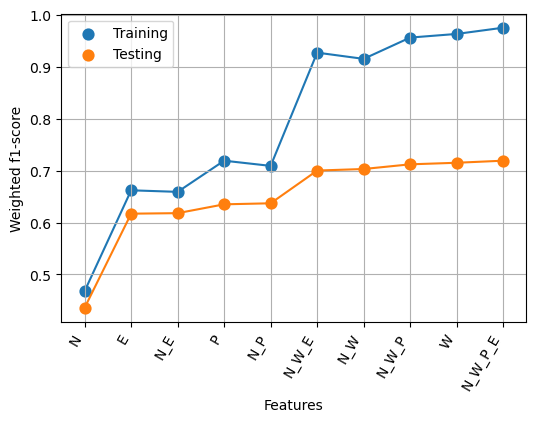

In [9]:
plot_train_test_score(df_score_train, df_score_test, method='SVM', order_by='f_wavg')

Plot the training times from `GridSearchCV`, sorted by increasing mean.

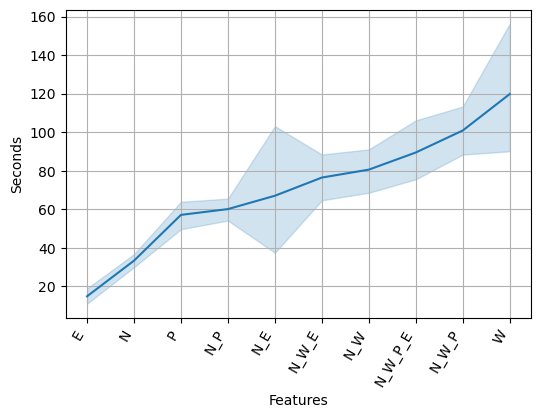

In [11]:
plot_train_time(models)

In [16]:
y_score = models['N_W_P_E'].best_estimator_.predict_proba(X_test[:, experiments['N_W_P_E']])
plot_roc_curve(y_test, y_score)

AttributeError: predict_proba is not available when  probability=False

List all training and testing scores, sorted by increasing weighted f1-score.

In [12]:
print('Training metrics:')
display(df_score_train.sort_values(by='f_wavg'))

print('Testing metrics:')
display(df_score_test.sort_values(by='f_wavg'))

Training metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,N,0.689,0.136,0.278,0.537,0.463,0.138,0.537,0.447,0.553,0.137,0.366,0.468
6,SVM,N_E,0.819,0.206,0.545,0.693,0.708,0.394,0.539,0.637,0.759,0.271,0.542,0.659
3,SVM,E,0.808,0.191,0.584,0.693,0.743,0.380,0.467,0.642,0.774,0.254,0.519,0.662
5,SVM,N_P,0.902,0.290,0.569,0.763,0.717,0.638,0.605,0.683,0.799,0.399,0.587,0.709
2,SVM,P,0.902,0.322,0.579,0.768,0.725,0.687,0.619,0.696,0.804,0.439,0.598,0.719
4,SVM,N_W,0.987,0.770,0.819,0.926,0.888,0.995,0.950,0.913,0.935,0.868,0.880,0.915
8,SVM,N_W_E,0.988,0.824,0.831,0.935,0.903,0.998,0.959,0.925,0.943,0.903,0.890,0.927
7,SVM,N_W_P,0.994,0.869,0.900,0.960,0.941,1.000,0.979,0.956,0.967,0.930,0.938,0.956
1,SVM,W,0.996,0.915,0.900,0.965,0.948,1.000,0.987,0.962,0.971,0.955,0.941,0.963
9,SVM,N_W_P_E,0.996,0.921,0.943,0.976,0.967,1.000,0.987,0.975,0.981,0.959,0.964,0.975


Testing metrics:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,SVM,N,0.633,0.099,0.303,0.484,0.447,0.116,0.489,0.420,0.524,0.107,0.374,0.436
3,SVM,E,0.739,0.191,0.591,0.636,0.772,0.299,0.384,0.614,0.755,0.233,0.466,0.617
6,SVM,N_E,0.751,0.200,0.576,0.640,0.734,0.343,0.426,0.607,0.742,0.253,0.490,0.618
2,SVM,P,0.815,0.244,0.530,0.673,0.721,0.517,0.413,0.615,0.765,0.332,0.464,0.635
5,SVM,N_P,0.820,0.241,0.565,0.685,0.719,0.557,0.402,0.616,0.766,0.336,0.469,0.637
8,SVM,N_W_E,0.803,0.359,0.621,0.703,0.821,0.430,0.535,0.699,0.812,0.391,0.575,0.700
4,SVM,N_W,0.809,0.351,0.633,0.709,0.822,0.457,0.525,0.701,0.816,0.397,0.574,0.703
7,SVM,N_W_P,0.803,0.389,0.638,0.711,0.852,0.413,0.530,0.716,0.827,0.400,0.579,0.712
1,SVM,W,0.798,0.424,0.634,0.711,0.858,0.371,0.558,0.722,0.827,0.396,0.594,0.715
9,SVM,N_W_P_E,0.796,0.408,0.669,0.717,0.880,0.382,0.524,0.727,0.836,0.394,0.587,0.719


## Save results to file

In [13]:
# Save the scoring metrics to file
score_saving(df_score_train, df_score_test, fname='SVM_score')

# Save the trained models to file
with bz2.open('../models/SVM.bz2', 'wb') as f:
    pickle.dump(models, f)

## Export results to LaTeX

In [14]:
to_latex(df_score_train)


\begin{tabular}{llrrrrrrrrrrrr}
\toprule
algorithm & features & p\_NFS & p\_UFS & p\_CFS & p\_wavg & r\_NFS & r\_UFS & r\_CFS & r\_wavg & f\_NFS & f\_UFS & f\_CFS & f\_wavg \\
\midrule
SVM & N & 0.689 & 0.136 & 0.278 & 0.537 & 0.463 & 0.138 & 0.537 & 0.447 & 0.553 & 0.137 & 0.366 & 0.468 \\
SVM & W & 0.996 & 0.915 & 0.900 & 0.965 & 0.948 & 1.000 & 0.987 & 0.962 & 0.971 & 0.955 & 0.941 & 0.963 \\
SVM & P & 0.902 & 0.322 & 0.579 & 0.768 & 0.725 & 0.687 & 0.619 & 0.696 & 0.804 & 0.439 & 0.598 & 0.719 \\
SVM & E & 0.808 & 0.191 & 0.584 & 0.693 & 0.743 & 0.380 & 0.467 & 0.642 & 0.774 & 0.254 & 0.519 & 0.662 \\
SVM & N\_W & 0.987 & 0.770 & 0.819 & 0.926 & 0.888 & 0.995 & 0.950 & 0.913 & 0.935 & 0.868 & 0.880 & 0.915 \\
SVM & N\_P & 0.902 & 0.290 & 0.569 & 0.763 & 0.717 & 0.638 & 0.605 & 0.683 & 0.799 & 0.399 & 0.587 & 0.709 \\
SVM & N\_E & 0.819 & 0.206 & 0.545 & 0.693 & 0.708 & 0.394 & 0.539 & 0.637 & 0.759 & 0.271 & 0.542 & 0.659 \\
SVM & N\_W\_P & 0.994 & 0.869 & 0.900 & 0.960 & 0.941 & 1

In [15]:
to_latex(df_score_test)

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
algorithm & features & p\_NFS & p\_UFS & p\_CFS & p\_wavg & r\_NFS & r\_UFS & r\_CFS & r\_wavg & f\_NFS & f\_UFS & f\_CFS & f\_wavg \\
\midrule
SVM & N & 0.633 & 0.099 & 0.303 & 0.484 & 0.447 & 0.116 & 0.489 & 0.420 & 0.524 & 0.107 & 0.374 & 0.436 \\
SVM & W & 0.798 & 0.424 & 0.634 & 0.711 & 0.858 & 0.371 & 0.558 & 0.722 & 0.827 & 0.396 & 0.594 & 0.715 \\
SVM & P & 0.815 & 0.244 & 0.530 & 0.673 & 0.721 & 0.517 & 0.413 & 0.615 & 0.765 & 0.332 & 0.464 & 0.635 \\
SVM & E & 0.739 & 0.191 & 0.591 & 0.636 & 0.772 & 0.299 & 0.384 & 0.614 & 0.755 & 0.233 & 0.466 & 0.617 \\
SVM & N\_W & 0.809 & 0.351 & 0.633 & 0.709 & 0.822 & 0.457 & 0.525 & 0.701 & 0.816 & 0.397 & 0.574 & 0.703 \\
SVM & N\_P & 0.820 & 0.241 & 0.565 & 0.685 & 0.719 & 0.557 & 0.402 & 0.616 & 0.766 & 0.336 & 0.469 & 0.637 \\
SVM & N\_E & 0.751 & 0.200 & 0.576 & 0.640 & 0.734 & 0.343 & 0.426 & 0.607 & 0.742 & 0.253 & 0.490 & 0.618 \\
SVM & N\_W\_P & 0.803 & 0.389 & 0.638 & 0.711 & 0.852 & 0